# Unsupervised clustering using procurement documents

In [ ]:
!pip install pyLDAvis pandarallel

In [ ]:
!mkdir -p tmp

In [21]:
import re
from ast import literal_eval
from collections import Counter
from collections import defaultdict

import gensim
import numpy as np
import pandas as pd
import pyLDAvis.gensim
import spacy
from gensim.models import LdaModel, CoherenceModel
from pandarallel import pandarallel
from pandas.core.reshape.util import cartesian_product
from scipy.spatial.distance import jensenshannon
from sklearn.cluster import AgglomerativeClustering
from tqdm import tqdm
from unidecode import unidecode

tqdm.pandas()
pyLDAvis.enable_notebook()
pandarallel.initialize(nb_workers=4, progress_bar=True)

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
cpv_labels = {
    "03": "Agricultural, farming, fishing, forestry and related products",
    "09": "Petroleum products, fuel, electricity and other sources of energy",
    "14": "Mining, basic metals and related products",
    "15": "Food, beverages, tobacco and related products",
    "16": "Agricultural machinery",
    "18": "Clothing, footwear, luggage articles and accessories",
    "19": "Leather and textile fabrics, plastic and rubber materials",
    "22": "Printed matter and related products",
    "24": "Chemical products",
    "30": "Office and computing machinery, equipment and supplies except furniture and software packages",
    "31": "Electrical machinery, apparatus, equipment and consumables; Lighting",
    "32": "Radio, television, communication, telecommunication and related equipment",
    "33": "Medical equipments, pharmaceuticals and personal care products",
    "34": "Transport equipment and auxiliary products to transportation",
    "35": "Security, fire-fighting, police and defence equipment",
    "37": "Musical instruments, sport goods, games, toys, handicraft, art materials and accessories",
    "38": "Laboratory, optical and precision equipments (excl. glasses)",
    "39": "Furniture (incl. office furniture), furnishings, domestic appliances (excl. lighting) and cleaning products",
    "41": "Collected and purified water",
    "42": "Industrial machinery",
    "43": "Machinery for mining, quarrying, construction equipment",
    "44": "Construction structures and materials; auxiliary products to construction (excepts electric apparatus)",
    "45": "Construction work",
    "48": "Software package and information systems",
    "50": "Repair and maintenance services",
    "51": "Installation services (except software)",
    "55": "Hotel, restaurant and retail trade services",
    "60": "Transport services (excl. Waste transport)",
    "63": "Supporting and auxiliary transport services; travel agencies services",
    "64": "Postal and telecommunications services",
    "65": "Public utilities",
    "66": "Financial and insurance services",
    "70": "Real estate services",
    "71": "Architectural, construction, engineering and inspection services",
    "72": "IT services: consulting, software development, Internet and support",
    "73": "Research and development services and related consultancy services",
    "75": "Administration, defence and social security services",
    "76": "Services related to the oil and gas industry",
    "77": "Agricultural, forestry, horticultural, aquacultural and apicultural services",
    "79": "Business services: law, marketing, consulting, recruitment, printing and security",
    "80": "Education and training services",
    "85": "Health and social work services",
    "90": "Sewage-, refuse-, cleaning-, and environmental services",
    "92": "Recreational, cultural and sporting services",
    "98": "Other community, social and personal services",
}

## Dataset loading

In [3]:
df = pd.read_csv("tmp/20230424-dataset-preprocessed-procurement-data-eu-notices.csv", index_col=0)
df

03     09     14     15     16     18     19     22  \
id                                                                          
2017/S 102-203726  False  False  False  False  False  False  False  False   
2014/S 138-246767  False  False  False  False  False  False  False  False   
2017/S 164-337354  False  False  False  False  False  False  False  False   
2016/S 070-121405  False  False  False  False  False  False  False  False   
2022/S 084-222910  False  False  False  False  False  False  False  False   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False  False  False  False  False   
2022/S 125-351443  False  False  False  False  False  False  False  False   
2022/S 101-278437  False  False  False  False  False  False  False  False   
2018/S 052-114411  False  False  False  False  False  False  False  False   
2019/S 118-288646  False  False  False  False  False  False  False  False   

                      24     30  ...     75     76     77     79     80  \
id                               ...                                      
2017/S 102-203726  False  False  ...  False  False  False  False  False   
2014/S 138-246767  False  False  ...  False  False  False  False   True   
2017/S 164-337354  False  False  ...  False  False  False  False   True   
2016/S 070-121405  False  False  ...  False  False  False  False  False   
2022/S 084-222910  False  False  ...  False  False  False  False  False   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  ...  False  False  False  False  False   
2022/S 125-351443  False  False  ...  False  False  False  False  False   
2022/S 101-278437  False  False  ...  False  False  False  False  False   
2018/S 052-114411  False  False  ...  False  False  False   True  False   
2019/S 118-288646  False  False  ...  False  False  False  False  False   

                      85     90     92     98  \
id                                              
2017/S 102-203726   True  False  False  False   
2014/S 138-246767  False  False  False  False   
2017/S 164-337354  False  False  False  False   
2016/S 070-121405  False  False  False  False   
2022/S 084-222910  False  False  False  False   
...                  ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False   
2022/S 125-351443  False  False  False  False   
2022/S 101-278437  False  False  False  False   
2018/S 052-114411  False  False  False  False   
2019/S 118-288646  False  False  False  False   

                                                                text  
id                                                                    
2017/S 102-203726  tender specificationsopen callreview july ecdc...  
2014/S 138-246767  annex po page technical specifications lot lan...  
2017/S 164-337354  tender page tenders framework contract provisi...  
2016/S 070-121405  pooling share cost noncooperation page tender ...  
2022/S 084-222910  european commission dg joint research centre d...  
...                                                              ...  
2020/S 106-255487  tendering specification tender eutm rca open p...  
2022/S 125-351443  order noeuropean commission joint research cen...  
2022/S 101-278437  tender specification regional seet procurement...  
2018/S 052-114411  model terms reference tender specification ass...  
2019/S 118-288646  framework contract lot supply small equipment ...  

[3797 rows x 46 columns]

In [4]:
df = df.dropna(subset=['text'])
df

03     09     14     15     16     18     19     22  \
id                                                                          
2017/S 102-203726  False  False  False  False  False  False  False  False   
2014/S 138-246767  False  False  False  False  False  False  False  False   
2017/S 164-337354  False  False  False  False  False  False  False  False   
2016/S 070-121405  False  False  False  False  False  False  False  False   
2022/S 084-222910  False  False  False  False  False  False  False  False   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False  False  False  False  False   
2022/S 125-351443  False  False  False  False  False  False  False  False   
2022/S 101-278437  False  False  False  False  False  False  False  False   
2018/S 052-114411  False  False  False  False  False  False  False  False   
2019/S 118-288646  False  False  False  False  False  False  False  False   

                      24     30  ...     75     76     77     79     80  \
id                               ...                                      
2017/S 102-203726  False  False  ...  False  False  False  False  False   
2014/S 138-246767  False  False  ...  False  False  False  False   True   
2017/S 164-337354  False  False  ...  False  False  False  False   True   
2016/S 070-121405  False  False  ...  False  False  False  False  False   
2022/S 084-222910  False  False  ...  False  False  False  False  False   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  ...  False  False  False  False  False   
2022/S 125-351443  False  False  ...  False  False  False  False  False   
2022/S 101-278437  False  False  ...  False  False  False  False  False   
2018/S 052-114411  False  False  ...  False  False  False   True  False   
2019/S 118-288646  False  False  ...  False  False  False  False  False   

                      85     90     92     98  \
id                                              
2017/S 102-203726   True  False  False  False   
2014/S 138-246767  False  False  False  False   
2017/S 164-337354  False  False  False  False   
2016/S 070-121405  False  False  False  False   
2022/S 084-222910  False  False  False  False   
...                  ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False   
2022/S 125-351443  False  False  False  False   
2022/S 101-278437  False  False  False  False   
2018/S 052-114411  False  False  False  False   
2019/S 118-288646  False  False  False  False   

                                                                text  
id                                                                    
2017/S 102-203726  tender specificationsopen callreview july ecdc...  
2014/S 138-246767  annex po page technical specifications lot lan...  
2017/S 164-337354  tender page tenders framework contract provisi...  
2016/S 070-121405  pooling share cost noncooperation page tender ...  
2022/S 084-222910  european commission dg joint research centre d...  
...                                                              ...  
2020/S 106-255487  tendering specification tender eutm rca open p...  
2022/S 125-351443  order noeuropean commission joint research cen...  
2022/S 101-278437  tender specification regional seet procurement...  
2018/S 052-114411  model terms reference tender specification ass...  
2019/S 118-288646  framework contract lot supply small equipment ...  

[3795 rows x 46 columns]

In [5]:
processed_docs = df["text"].apply(lambda x: x.split(" "))

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## First training

### LDA training

In [6]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=18, id2word=dictionary, passes=10, workers=8,
                                       minimum_probability=0.0)
for idx, topic in lda_model.print_topics(-1):
    print('-- Topic: {} --\n{}\n'.format(idx, topic))

-- Topic: 0 --
0.020*"eea" + 0.013*"exercise" + 0.011*"land" + 0.008*"copernicus" + 0.007*"module" + 0.007*"lot" + 0.006*"o" + 0.006*"trainer" + 0.006*"border" + 0.005*"m"

-- Topic: 1 --
0.038*"efsa" + 0.013*"safety" + 0.011*"easa" + 0.011*"aviation" + 0.011*"esubmission" + 0.009*"revision" + 0.007*"certify" + 0.007*"proprietary" + 0.007*"intranet" + 0.006*"easainternet"

-- Topic: 2 --
0.034*"easo" + 0.019*"de" + 0.017*"ep" + 0.009*"la" + 0.008*"daily" + 0.008*"platform" + 0.007*"media" + 0.007*"et" + 0.007*"press" + 0.007*"news"

-- Topic: 3 --
0.027*"building" + 0.014*"construction" + 0.013*"europol" + 0.013*"water" + 0.012*"eib" + 0.010*"energy" + 0.009*"consultant" + 0.007*"floor" + 0.006*"facility" + 0.006*"o"

-- Topic: 4 --
0.240*"text" + 0.219*"autocad" + 0.028*"etf" + 0.019*"de" + 0.010*"fee" + 0.009*"en" + 0.009*"van" + 0.007*"het" + 0.007*"petten" + 0.004*"translation"

-- Topic: 5 --
0.014*"health" + 0.011*"o" + 0.011*"session" + 0.010*"food" + 0.006*"dg" + 0.006*"interim

In [9]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


In [11]:
pyLDAvis.save_html(vis, 'tmp/20230508-lda.html')

### Clustering

In [12]:
doc_topics = lda_model.get_document_topics(bow_corpus)

In [17]:
doc_probabilities = np.zeros((len(bow_corpus), lda_model.num_topics))
for doc_id, topics in enumerate(doc_topics):
    for topic, prob in topics:
        doc_probabilities[doc_id, topic] = prob

In [22]:
distance_matrix = np.zeros((len(bow_corpus), len(bow_corpus)))
for doc1_id in tqdm(range(len(bow_corpus)), total=len(bow_corpus)):
    for doc2_id in range(len(bow_corpus)):
        distance_matrix[doc1_id, doc2_id] = jensenshannon(doc_probabilities[doc1_id], doc_probabilities[doc2_id])

  6%|▌         | 224/3795 [00:14<04:27, 13.33it/s]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|██████████| 3795/3795 [04:54<00:00, 12.91it/s]


In [29]:
distance_matrix[np.isnan(distance_matrix)] = -1

In [23]:
clustering_model = AgglomerativeClustering(n_clusters=5, affinity='precomputed', linkage='average')

In [31]:
clusters = clustering_model.fit_predict(distance_matrix)

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [44]:
doc_clusters = []
for doc_id, cluster_id in enumerate(clusters):
    for i in range(len(doc_clusters), cluster_id + 1):
        doc_clusters.append([])
    doc_clusters[cluster_id].append(df.iloc[doc_id]["text"])

In [46]:
for cluster_id, cluster_docs in enumerate(doc_clusters):
    print(f"Cluster {cluster_id}: {len(cluster_docs)} docs")

Cluster 0: 3221 docs
Cluster 1: 108 docs
Cluster 2: 145 docs
Cluster 3: 174 docs
Cluster 4: 147 docs


In [77]:
def top_words(texts: list[str]) -> list[tuple[str, int]]:
    word_dictionary = defaultdict(int)
    for text in texts:
        for word in text.split():
            if word:
                word_dictionary[word] += 1
    top_words = sorted(word_dictionary.items(), key=lambda x: x[1], reverse=True)
    return [t for t in top_words if t[0] in dictionary.token2id.keys() and len(t[0]) > 3]

In [78]:
top_words(doc_clusters[0])[0:20]

[('text', 35437),
 ('autocad', 28900),
 ('test', 20001),
 ('maintenance', 17806),
 ('building', 16167),
 ('software', 15961),
 ('energy', 15595),
 ('assignment', 14098),
 ('interim', 13781),
 ('sector', 13234),
 ('frontex', 13019),
 ('platform', 13014),
 ('safety', 12471),
 ('esubmission', 11958),
 ('survey', 11877),
 ('health', 11677),
 ('workshop', 10536),
 ('skill', 10419),
 ('infrastructure', 10216),
 ('candidate', 10199)]

In [79]:
top_words(doc_clusters[1])[0:20]

[('publications', 11208),
 ('freelancer', 3022),
 ('software', 2390),
 ('freelance', 1734),
 ('takeover', 1596),
 ('parf', 1487),
 ('text', 1447),
 ('court', 1379),
 ('maintenance', 1364),
 ('estimation', 1363),
 ('test', 1360),
 ('questionnaire', 1354),
 ('correction', 1095),
 ('monthly', 1051),
 ('translation', 998),
 ('handover', 912),
 ('error', 909),
 ('metadata', 835),
 ('freelancing', 831),
 ('planning', 823)]

In [80]:
top_words(doc_clusters[2])[0:20]

[('defence', 3420),
 ('esubmission', 2609),
 ('capability', 1985),
 ('interface', 1534),
 ('copernicus', 1441),
 ('mapping', 1301),
 ('kickoff', 1290),
 ('emergency', 1252),
 ('upload', 1221),
 ('clarification', 1209),
 ('mission', 1064),
 ('validation', 1048),
 ('military', 1011),
 ('opening', 991),
 ('satellite', 982),
 ('workshop', 943),
 ('activation', 930),
 ('package', 926),
 ('scenario', 893),
 ('input', 874)]

In [81]:
top_words(doc_clusters[3])[0:20]

[('eurostat', 14395),
 ('statistical', 5033),
 ('statistic', 4597),
 ('estat', 3052),
 ('replacement', 2119),
 ('validation', 2036),
 ('questionnaire', 1952),
 ('timetable', 1799),
 ('statistics', 1701),
 ('transport', 1701),
 ('reply', 1646),
 ('indicator', 1551),
 ('survey', 1543),
 ('luxembourg', 1532),
 ('mission', 1470),
 ('collection', 1452),
 ('methodological', 1325),
 ('esubmission', 1272),
 ('eurostats', 1141),
 ('opening', 1140)]

In [82]:
top_words(doc_clusters[4])[0:20]

[('efsa', 10130),
 ('safety', 3248),
 ('easa', 3235),
 ('aviation', 2780),
 ('esubmission', 2592),
 ('revision', 2237),
 ('certify', 1948),
 ('proprietary', 1890),
 ('intranet', 1884),
 ('easainternet', 1878),
 ('guidance', 1289),
 ('food', 1225),
 ('test', 1196),
 ('upload', 1176),
 ('scientific', 1174),
 ('session', 898),
 ('software', 831),
 ('opening', 805),
 ('emission', 740),
 ('assignment', 716)]

## First fine-tuning pass

In [54]:
def lda_coherence(bow_corpus, dictionary, processed_docs, topic_count: int, passes: int = 1, alpha='symmetric',
                  eta=None):
    model = LdaModel(bow_corpus, num_topics=topic_count, id2word=dictionary, passes=passes, alpha=alpha, eta=eta,
                     minimum_probability=0.0, random_state=0)
    coherence_model = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary,
                                     coherence='c_v', processes=1)
    return coherence_model.get_coherence()

### Find best number of topics

In [13]:
results = pd.DataFrame(list(range(2, 200, 2)), columns=["topic_count"])
results

topic_count
0             2
1             4
2             6
3             8
4            10
5            12
6            14
7            16
8            18
9            20
10           22
11           24
12           26
13           28
14           30
15           32
16           34
17           36
18           38
19           40
20           42
21           44
22           46
23           48
24           50
25           52
26           54
27           56
28           58
29           60
30           62
31           64
32           66
33           68
34           70
35           72
36           74
37           76
38           78
39           80
40           82
41           84
42           86
43           88
44           90
45           92
46           94
47           96
48           98

In [ ]:
results["coherence"] = results["topic_count"].parallel_apply(lambda x, c, d, p: lda_coherence(c, d, p, x),
                                                             args=(bow_corpus, dictionary, processed_docs,))

In [ ]:
results.to_csv("tmp/20230508-clustering-finetuning-topic-count.csv")

In [24]:
results = pd.read_csv("tmp/20230508-clustering-finetuning-topic-count.csv")

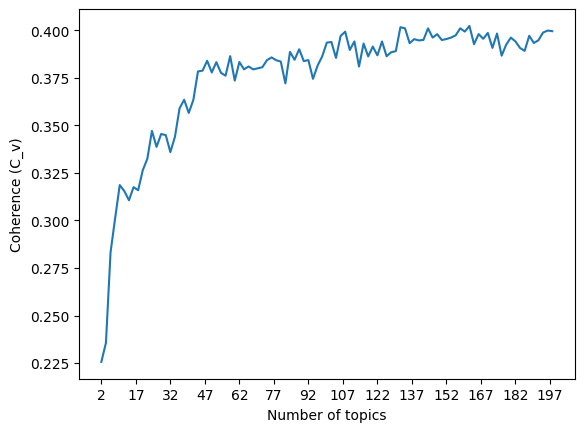

In [27]:
from matplotlib import pyplot as plt

plt.plot(results["topic_count"], results["coherence"])
plt.xticks(range(2, 200, 15), range(2, 200, 15))
plt.xlabel("Number of topics")
plt.ylabel("Coherence (C_v)")
plt.show()

### Train model with 130 topics

In [6]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=130, id2word=dictionary, passes=1, workers=8,
                                       minimum_probability=0.0)
for idx, topic in lda_model.print_topics(-1):
    print('-- Topic: {} --\n{}\n'.format(idx, topic))

-- Topic: 0 --
0.007*"building" + 0.007*"interim" + 0.006*"easo" + 0.006*"text" + 0.005*"frontex" + 0.005*"eib" + 0.005*"safety" + 0.004*"autocad" + 0.004*"eda" + 0.004*"o"

-- Topic: 1 --
0.006*"o" + 0.006*"software" + 0.005*"sector" + 0.004*"skill" + 0.004*"lot" + 0.004*"energy" + 0.004*"digital" + 0.004*"test" + 0.004*"eurostat" + 0.003*"platform"

-- Topic: 2 --
0.010*"ecdc" + 0.007*"lot" + 0.007*"eda" + 0.006*"energy" + 0.005*"conference" + 0.003*"publications" + 0.003*"m" + 0.003*"software" + 0.003*"maintenance" + 0.003*"skill"

-- Topic: 3 --
0.009*"eea" + 0.007*"eurostat" + 0.005*"lot" + 0.004*"statistic" + 0.004*"statistical" + 0.004*"o" + 0.004*"esubmission" + 0.004*"ecdc" + 0.003*"m" + 0.003*"sector"

-- Topic: 4 --
0.006*"o" + 0.004*"platform" + 0.004*"test" + 0.004*"maintenance" + 0.004*"software" + 0.003*"building" + 0.003*"interim" + 0.003*"eurostat" + 0.003*"medical" + 0.003*"jrc"

-- Topic: 5 --
0.012*"di" + 0.008*"o" + 0.008*"lot" + 0.008*"easo" + 0.006*"frontex" + 0.

In [8]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, 'tmp/20230511-lda-130topics.html')

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


Almost all topics are aggregated in one "place", and it's not easy to determine to what each topic refers.

### Train model with 130 topics with more passes

In [9]:
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=130, id2word=dictionary, passes=5, workers=8,
                                       minimum_probability=0.0)
for idx, topic in lda_model.print_topics(-1):
    print('-- Topic: {} --\n{}\n'.format(idx, topic))

-- Topic: 0 --
0.077*"di" + 0.052*"de" + 0.041*"la" + 0.025*"le" + 0.021*"del" + 0.020*"il" + 0.018*"o" + 0.017*"et" + 0.016*"les" + 0.015*"des"

-- Topic: 1 --
0.031*"m" + 0.016*"frontex" + 0.013*"border" + 0.010*"root" + 0.009*"forecast" + 0.008*"weather" + 0.008*"parameter" + 0.008*"sensor" + 0.007*"integrity" + 0.006*"station"

-- Topic: 2 --
0.007*"audience" + 0.006*"emas" + 0.006*"supplier" + 0.006*"thirdparty" + 0.005*"parliaments" + 0.005*"paragraph" + 0.005*"eplo" + 0.005*"liaison" + 0.005*"campaign" + 0.004*"offence"

-- Topic: 3 --
0.022*"session" + 0.019*"food" + 0.017*"o" + 0.017*"tutor" + 0.015*"btsf" + 0.012*"health" + 0.011*"animal" + 0.009*"chafea" + 0.008*"interim" + 0.008*"train"

-- Topic: 4 --
0.029*"health" + 0.012*"ema" + 0.011*"medicine" + 0.009*"o" + 0.007*"healthcare" + 0.006*"agencys" + 0.006*"executive" + 0.006*"safety" + 0.006*"workshop" + 0.005*"patient"

-- Topic: 5 --
0.066*"transport" + 0.015*"rail" + 0.014*"erdf" + 0.014*"passenger" + 0.013*"road" + 0.

In [10]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, 'tmp/20230511-lda-130topics-10passes.html')

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


More passes seems to create more spread topics, so need to train with more passes.

Also, we observe a lot of noises in the words, need to cleanup the dataset:
-[Use Spacy Named Entity Recognition](https://medium.com/spatial-data-science/how-to-extract-locations-from-text-with-natural-language-processing-9b77035b3ea4) to remove PERSON, NORP, ORG, GPE, LOC, DATE, TIME, PERCENT, QUANTITY, ORDINAL, CARDINAL
- Remove all words with less than 3 letters
- Remove acronyms (upper case words with more than one letter) -> will actually be removed using NER

## Improved dataset processing

In [18]:
df = pd.read_csv("tmp/20230301-procurement_data_for_eu_notices.csv", index_col=0)
df

notice_type  main_cpv additional_cpvs  \
id                                                             
2017/S 102-203726  Contract notice  85100000              []   
2014/S 138-246767  Contract notice  80580000              []   
2017/S 164-337354  Contract notice  80600000              []   
2016/S 070-121405  Contract notice  73000000              []   
2022/S 084-222910  Contract notice  71000000              []   
...                            ...       ...             ...   
2020/S 106-255487  Contract notice  34113200              []   
2022/S 125-351443  Contract notice  48461000              []   
2022/S 101-278437  Contract notice  63500000              []   
2018/S 052-114411  Contract notice  79300000              []   
2019/S 118-288646  Contract notice  31682210              []   

                                                      etendering_url  \
id                                                                     
2017/S 102-203726  https://etendering.ted.europa.eu/cft/cft-displ...   
2014/S 138-246767  https://etendering.ted.europa.eu/cft/cft-displ...   
2017/S 164-337354  https://etendering.ted.europa.eu/cft/cft-displ...   
2016/S 070-121405  https://etendering.ted.europa.eu/cft/cft-displ...   
2022/S 084-222910  https://etendering.ted.europa.eu/cft/cft-displ...   
...                                                              ...   
2020/S 106-255487  https://etendering.ted.europa.eu/cft/cft-displ...   
2022/S 125-351443  https://etendering.ted.europa.eu/cft/cft-displ...   
2022/S 101-278437  https://etendering.ted.europa.eu/cft/cft-displ...   
2018/S 052-114411  https://etendering.ted.europa.eu/cft/cft-displ...   
2019/S 118-288646  https://etendering.ted.europa.eu/cft/cft-displ...   

                                                    procurement_data  
id                                                                    
2017/S 102-203726  ['Tender Specificationsopen callreview july 20...  
2014/S 138-246767  ['Annex12013POEJ4.DOCX ANNEX 1 2014/PO/EJ/10 P...  
2017/S 164-337354  ['4102cahierdeschargesopenprocedureenjuly2010....  
2016/S 070-121405  ['4102cahierdeschargesopenprocedureenjuly2010....  
2022/S 084-222910  ['European Commission DG Joint Research Centre...  
...                                                              ...  
2020/S 106-255487  ['1 TENDERING SPECIFICATIONS Call for tenders ...  
2022/S 125-351443  ['ORDER NOEUROPEAN COMMISSION JOINT RESEARCH C...  
2022/S 101-278437  ['22ETF02 Tender specifications Regional SEET ...  
2018/S 052-114411  ['MODEL TERMS OF REFERENCE TENDER SPECIFICATIO...  
2019/S 118-288646  ['index.php NE.45.2301.A.022 ND.45.1001011.A.0...  

[3823 rows x 5 columns]

In [19]:
df["text"] = df["procurement_data"].apply(lambda d: " ".join(literal_eval(d)))
for cpv_code in cpv_labels.keys():
    df[cpv_code] = df.apply(lambda r: any(
        str(c).startswith(cpv_code)
        for c in literal_eval(r["additional_cpvs"]) + [str(r["main_cpv"])]
    ), axis=1)
df = df[list(cpv_labels.keys()) + ["text"]]
df

03     09     14     15     16     18     19     22  \
id                                                                          
2017/S 102-203726  False  False  False  False  False  False  False  False   
2014/S 138-246767  False  False  False  False  False  False  False  False   
2017/S 164-337354  False  False  False  False  False  False  False  False   
2016/S 070-121405  False  False  False  False  False  False  False  False   
2022/S 084-222910  False  False  False  False  False  False  False  False   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False  False  False  False  False   
2022/S 125-351443  False  False  False  False  False  False  False  False   
2022/S 101-278437  False  False  False  False  False  False  False  False   
2018/S 052-114411  False  False  False  False  False  False  False  False   
2019/S 118-288646  False  False  False  False  False  False  False  False   

                      24     30  ...     75     76     77     79     80  \
id                               ...                                      
2017/S 102-203726  False  False  ...  False  False  False  False  False   
2014/S 138-246767  False  False  ...  False  False  False  False   True   
2017/S 164-337354  False  False  ...  False  False  False  False   True   
2016/S 070-121405  False  False  ...  False  False  False  False  False   
2022/S 084-222910  False  False  ...  False  False  False  False  False   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  ...  False  False  False  False  False   
2022/S 125-351443  False  False  ...  False  False  False  False  False   
2022/S 101-278437  False  False  ...  False  False  False  False  False   
2018/S 052-114411  False  False  ...  False  False  False   True  False   
2019/S 118-288646  False  False  ...  False  False  False  False  False   

                      85     90     92     98  \
id                                              
2017/S 102-203726   True  False  False  False   
2014/S 138-246767  False  False  False  False   
2017/S 164-337354  False  False  False  False   
2016/S 070-121405  False  False  False  False   
2022/S 084-222910  False  False  False  False   
...                  ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False   
2022/S 125-351443  False  False  False  False   
2022/S 101-278437  False  False  False  False   
2018/S 052-114411  False  False  False  False   
2019/S 118-288646  False  False  False  False   

                                                                text  
id                                                                    
2017/S 102-203726  Tender Specificationsopen callreview july 2015...  
2014/S 138-246767  Annex12013POEJ4.DOCX ANNEX 1 2014/PO/EJ/10 Pag...  
2017/S 164-337354  4102cahierdeschargesopenprocedureenjuly2010.do...  
2016/S 070-121405  4102cahierdeschargesopenprocedureenjuly2010.do...  
2022/S 084-222910  European Commission DG Joint Research Centre D...  
...                                                              ...  
2020/S 106-255487  1 TENDERING SPECIFICATIONS Call for tenders EU...  
2022/S 125-351443  ORDER NOEUROPEAN COMMISSION JOINT RESEARCH CEN...  
2022/S 101-278437  22ETF02 Tender specifications Regional SEET PR...  
2018/S 052-114411  MODEL TERMS OF REFERENCE TENDER SPECIFICATIONS...  
2019/S 118-288646  index.php NE.45.2301.A.022 ND.45.1001011.A.014...  

[3823 rows x 46 columns]

In [21]:
df = df[df["text"].str.len() < 1_000_000]
df

03     09     14     15     16     18     19     22  \
id                                                                          
2017/S 102-203726  False  False  False  False  False  False  False  False   
2014/S 138-246767  False  False  False  False  False  False  False  False   
2017/S 164-337354  False  False  False  False  False  False  False  False   
2016/S 070-121405  False  False  False  False  False  False  False  False   
2022/S 084-222910  False  False  False  False  False  False  False  False   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False  False  False  False  False   
2022/S 125-351443  False  False  False  False  False  False  False  False   
2022/S 101-278437  False  False  False  False  False  False  False  False   
2018/S 052-114411  False  False  False  False  False  False  False  False   
2019/S 118-288646  False  False  False  False  False  False  False  False   

                      24     30  ...     75     76     77     79     80  \
id                               ...                                      
2017/S 102-203726  False  False  ...  False  False  False  False  False   
2014/S 138-246767  False  False  ...  False  False  False  False   True   
2017/S 164-337354  False  False  ...  False  False  False  False   True   
2016/S 070-121405  False  False  ...  False  False  False  False  False   
2022/S 084-222910  False  False  ...  False  False  False  False  False   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  ...  False  False  False  False  False   
2022/S 125-351443  False  False  ...  False  False  False  False  False   
2022/S 101-278437  False  False  ...  False  False  False  False  False   
2018/S 052-114411  False  False  ...  False  False  False   True  False   
2019/S 118-288646  False  False  ...  False  False  False  False  False   

                      85     90     92     98  \
id                                              
2017/S 102-203726   True  False  False  False   
2014/S 138-246767  False  False  False  False   
2017/S 164-337354  False  False  False  False   
2016/S 070-121405  False  False  False  False   
2022/S 084-222910  False  False  False  False   
...                  ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False   
2022/S 125-351443  False  False  False  False   
2022/S 101-278437  False  False  False  False   
2018/S 052-114411  False  False  False  False   
2019/S 118-288646  False  False  False  False   

                                                                text  
id                                                                    
2017/S 102-203726  Tender Specificationsopen callreview july 2015...  
2014/S 138-246767  Annex12013POEJ4.DOCX ANNEX 1 2014/PO/EJ/10 Pag...  
2017/S 164-337354  4102cahierdeschargesopenprocedureenjuly2010.do...  
2016/S 070-121405  4102cahierdeschargesopenprocedureenjuly2010.do...  
2022/S 084-222910  European Commission DG Joint Research Centre D...  
...                                                              ...  
2020/S 106-255487  1 TENDERING SPECIFICATIONS Call for tenders EU...  
2022/S 125-351443  ORDER NOEUROPEAN COMMISSION JOINT RESEARCH CEN...  
2022/S 101-278437  22ETF02 Tender specifications Regional SEET PR...  
2018/S 052-114411  MODEL TERMS OF REFERENCE TENDER SPECIFICATIONS...  
2019/S 118-288646  index.php NE.45.2301.A.022 ND.45.1001011.A.014...  

[3797 rows x 46 columns]

In [26]:
NLP = spacy.load("en_core_web_sm", disable=["tokenizer", "textcat"])  # disable unused models to speed up
NLP.max_length = df["text"].str.len().max()

In [47]:
def process_text_old(text: str, NLP) -> str:
    tokens = NLP(text)
    words = [unidecode(t.lemma_.lower()) for t in tokens if t.is_alpha and not t.is_stop and not t.is_digit]
    return " ".join(words)


NER_IDS_TO_REMOVE = ["PERSON", "NORP", "ORG", "GPE", "LOC", "DATE", "TIME", "PERCENT", "QUANTITY", "ORDINAL",
                     "CARDINAL"]
ACRONYM_REGEX = re.compile("[A-Z]{2,}")


def process_text(text: str, NLP) -> str:
    tokens = NLP(text)
    words = [unidecode(t.lemma_.lower()) for t in tokens if
             t.is_alpha and not t.is_stop and not t.is_digit and t.ent_type_ not in NER_IDS_TO_REMOVE and len(
                 t.lemma_) > 2 and not ACRONYM_REGEX.match(t.text)]
    return " ".join(words)

In [48]:
# Initial text
text = df.iloc[0]["text"]
text, len(text)

('Tender Specificationsopen callreview july 2015 ECDC Procurement Tender Specifications open 2016 Version 1.3 Tender Specifications for Monitoring influenza vaccine effectiveness (seasonal and pandemic) in EU/EEA Framework service contract Publication Reference: OJ/2017/OCS/9269 May 2017 Table of Contents Introduction to ECDC ..............................................................................................................................................3 1 Overview of this tender ..................................................................................................................................4 1.1 Description of the contract .................................................................................................................4 1.2 Timetable ............................................................................................................................................4 1.3 Participation in the tender procedure .........................

In [49]:
# Old processing
text = process_text_old(df.iloc[0]["text"], NLP)
text, len(text)

('tender specificationsopen callreview july ecdc procurement tender specifications open version tender specifications monitor influenza vaccine effectiveness seasonal pandemic eu eea framework service contract publication reference table contents introduction ecdc overview tender description contract timetable participation tender procedure participation consortium subcontract presentation tender contacts ecdc tenderer division lot variant confidentiality public access document contractual detail electronic exchange document additional information term reference background invitation tender description service scope contract price exclusion selection criterion exclusion criterion selection criterion award contract technical proposal technical evaluation financial proposal choice select tender obligation award notification outcome list annexes introduction ecdc european centre disease prevention control ecdc agency european union establish european parliament council regulation april pu

In [50]:
# New processing
text = process_text(df.iloc[0]["text"], NLP)
text, len(text)

('tender specificationsopen callreview procurement tender specifications open tender specifications monitor influenza vaccine effectiveness seasonal pandemic service contract publication reference table contents introduction overview tender description contract timetable participation tender procedure participation consortium subcontract tender contacts tenderer lot variant confidentiality public access document contractual detail electronic exchange document additional information term reference background invitation tender description service scope contract exclusion selection criterion exclusion criterion selection criterion award contract technical proposal technical evaluation financial proposal choice select tender obligation award notification outcome list annexes introduction prevention control agency establish purpose identify assess communicate current emerge threat human health communicable disease broad mission statement main technical task fall follow category publication 

In [51]:
df["text"] = df["text"].parallel_apply(process_text, args=(NLP,))

In [52]:
df.to_csv("tmp/20230511-dataset-preprocessed-procurement-data-eu-notices.csv")

In [3]:
df = pd.read_csv("tmp/20230511-dataset-preprocessed-procurement-data-eu-notices.csv", index_col=0)
df = df.dropna(subset=['text'])
df

03     09     14     15     16     18     19     22  \
id                                                                          
2017/S 102-203726  False  False  False  False  False  False  False  False   
2014/S 138-246767  False  False  False  False  False  False  False  False   
2017/S 164-337354  False  False  False  False  False  False  False  False   
2016/S 070-121405  False  False  False  False  False  False  False  False   
2022/S 084-222910  False  False  False  False  False  False  False  False   
...                  ...    ...    ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False  False  False  False  False   
2022/S 125-351443  False  False  False  False  False  False  False  False   
2022/S 101-278437  False  False  False  False  False  False  False  False   
2018/S 052-114411  False  False  False  False  False  False  False  False   
2019/S 118-288646  False  False  False  False  False  False  False  False   

                      24     30  ...     75     76     77     79     80  \
id                               ...                                      
2017/S 102-203726  False  False  ...  False  False  False  False  False   
2014/S 138-246767  False  False  ...  False  False  False  False   True   
2017/S 164-337354  False  False  ...  False  False  False  False   True   
2016/S 070-121405  False  False  ...  False  False  False  False  False   
2022/S 084-222910  False  False  ...  False  False  False  False  False   
...                  ...    ...  ...    ...    ...    ...    ...    ...   
2020/S 106-255487  False  False  ...  False  False  False  False  False   
2022/S 125-351443  False  False  ...  False  False  False  False  False   
2022/S 101-278437  False  False  ...  False  False  False  False  False   
2018/S 052-114411  False  False  ...  False  False  False   True  False   
2019/S 118-288646  False  False  ...  False  False  False  False  False   

                      85     90     92     98  \
id                                              
2017/S 102-203726   True  False  False  False   
2014/S 138-246767  False  False  False  False   
2017/S 164-337354  False  False  False  False   
2016/S 070-121405  False  False  False  False   
2022/S 084-222910  False  False  False  False   
...                  ...    ...    ...    ...   
2020/S 106-255487  False  False  False  False   
2022/S 125-351443  False  False  False  False   
2022/S 101-278437  False  False  False  False   
2018/S 052-114411  False  False  False  False   
2019/S 118-288646  False  False  False  False   

                                                                text  
id                                                                    
2017/S 102-203726  tender specificationsopen callreview procureme...  
2014/S 138-246767  page technical specifications lot languages pr...  
2017/S 164-337354  tender page tenders framework contract provisi...  
2016/S 070-121405  cost noncooperation page open procedure poolin...  
2022/S 084-222910  multiple framework service contract perform de...  
...                                                              ...  
2020/S 106-255487  tender open procedure purchasing allterrain ar...  
2022/S 125-351443  retieseweg fax good supply order place follow ...  
2022/S 101-278437  tender specification regional incountry suppor...  
2018/S 052-114411  assessment cost provide wholesale voice termin...  
2019/S 118-288646  framework contract lot supply small equipment ...  

[3794 rows x 46 columns]

In [89]:
{c: df[c].sum() for c in cpv_labels.keys()}

{'03': 0,
 '09': 0,
 '14': 2,
 '15': 4,
 '16': 0,
 '18': 7,
 '19': 2,
 '22': 17,
 '24': 13,
 '30': 60,
 '31': 17,
 '32': 38,
 '33': 35,
 '34': 26,
 '35': 45,
 '37': 1,
 '38': 97,
 '39': 39,
 '41': 0,
 '42': 16,
 '43': 0,
 '44': 10,
 '45': 26,
 '48': 45,
 '50': 66,
 '51': 9,
 '55': 33,
 '60': 42,
 '63': 54,
 '64': 63,
 '65': 5,
 '66': 73,
 '70': 7,
 '71': 167,
 '72': 406,
 '73': 493,
 '75': 23,
 '76': 1,
 '77': 28,
 '79': 1105,
 '80': 188,
 '85': 110,
 '90': 336,
 '92': 95,
 '98': 26}

In [4]:
df = df.dropna(subset=['text'])
processed_docs = df["text"].apply(lambda x: x.split(" "))

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Second fine-tuning pass

### Find best number of topics

In [8]:
def lda_coherence(bow_corpus, dictionary, processed_docs, topic_count: int, passes: int = 10, alpha='symmetric',
                  eta=None):
    model = LdaModel(bow_corpus, num_topics=topic_count, id2word=dictionary, passes=passes, alpha=alpha, eta=eta,
                     minimum_probability=0.0, random_state=0)
    coherence_model = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary,
                                     coherence='c_v', processes=1)
    return coherence_model.get_coherence()

In [9]:
results = pd.DataFrame(list(range(2, 200, 20)), columns=["topic_count"])
results

topic_count
0            2
1           22
2           42
3           62
4           82
5          102
6          122
7          142
8          162
9          182

In [10]:
results["coherence"] = results["topic_count"].parallel_apply(lambda x, c, d, p: lda_coherence(c, d, p, x),
                                                             args=(bow_corpus, dictionary, processed_docs,))

In [11]:
results.to_csv("tmp/20230511-clustering-finetuning-topic-count.csv")

In [12]:
results = pd.read_csv("tmp/20230511-clustering-finetuning-topic-count.csv")

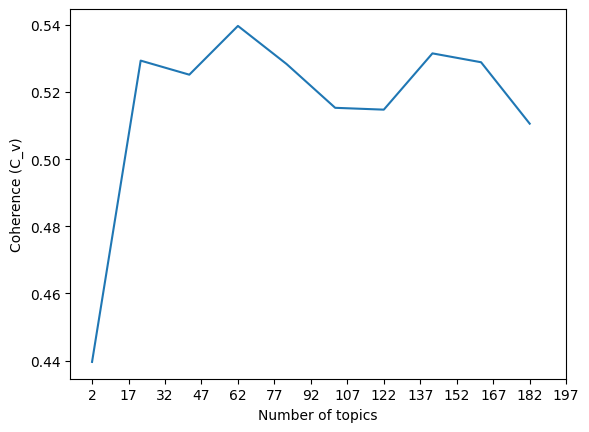

In [13]:
from matplotlib import pyplot as plt

plt.plot(results["topic_count"], results["coherence"])
plt.xticks(range(2, 200, 15), range(2, 200, 15))
plt.xlabel("Number of topics")
plt.ylabel("Coherence (C_v)")
plt.show()

Best number of topics between 20 and 90

In [15]:
results = pd.DataFrame(list(range(20, 90, 5)), columns=["topic_count"])
results

topic_count
0            20
1            25
2            30
3            35
4            40
5            45
6            50
7            55
8            60
9            65
10           70
11           75
12           80
13           85

In [16]:
results["coherence"] = results["topic_count"].parallel_apply(lambda x, c, d, p: lda_coherence(c, d, p, x),
                                                             args=(bow_corpus, dictionary, processed_docs,))

In [17]:
results.to_csv("tmp/20230511-clustering-finetuning-topic-count-2.csv")

In [67]:
results = pd.read_csv("tmp/20230511-clustering-finetuning-topic-count-2.csv")

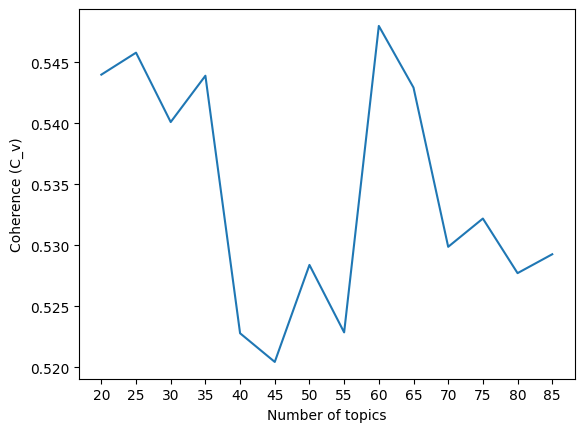

In [68]:
from matplotlib import pyplot as plt

plt.plot(results["topic_count"], results["coherence"])
plt.xticks(range(20, 90, 5), range(20, 90, 5))
plt.xlabel("Number of topics")
plt.ylabel("Coherence (C_v)")
plt.show()

Score is the highest with 62 topics

In [9]:
lda_model = LdaModel(bow_corpus, num_topics=62, id2word=dictionary, passes=10, alpha='symmetric', eta=None,
                     minimum_probability=0.0, random_state=0)
for idx, topic in lda_model.print_topics(-1):
    print('-- Topic: {} --\n{}\n'.format(idx, topic))

-- Topic: 0 --
0.027*"insurance" + 0.020*"visitor" + 0.015*"building" + 0.014*"facility" + 0.012*"centre" + 0.012*"mail" + 0.011*"visit" + 0.009*"room" + 0.008*"floor" + 0.007*"space"

-- Topic: 1 --
0.095*"platform" + 0.037*"web" + 0.023*"portal" + 0.015*"search" + 0.013*"functionality" + 0.008*"host" + 0.007*"interface" + 0.007*"infrastructure" + 0.007*"community" + 0.006*"maintenance"

-- Topic: 2 --
0.024*"involved" + 0.016*"participant" + 0.015*"sole" + 0.014*"insert" + 0.014*"upload" + 0.012*"worker" + 0.011*"parties" + 0.010*"lot" + 0.010*"signatory" + 0.008*"euratom"

-- Topic: 3 --
0.025*"map" + 0.024*"emergency" + 0.022*"ref" + 0.017*"yes" + 0.017*"interface" + 0.015*"deployment" + 0.014*"activation" + 0.012*"crisis" + 0.011*"mapping" + 0.011*"dataset"

-- Topic: 4 --
0.013*"services" + 0.011*"insurance" + 0.010*"claim" + 0.009*"assignment" + 0.008*"beneficiary" + 0.008*"audits" + 0.007*"auditor" + 0.007*"category" + 0.006*"employee" + 0.005*"damage"

-- Topic: 5 --
0.057*"in

### Impact of the number of passes on model performance

In [58]:
def float_or_str(value: str) -> float | str:
    try:
        return float(value)
    except ValueError:
        return value


def lda_coherence(bow_corpus, dictionary, processed_docs, topic_count: int, passes: int = 10, alpha='symmetric',
                  eta=None):
    alpha = float_or_str(alpha)
    eta = float_or_str(eta)
    model = LdaModel(bow_corpus, num_topics=topic_count, id2word=dictionary, passes=passes, alpha=alpha, eta=eta,
                     minimum_probability=0.0, random_state=0)
    coherence_model = CoherenceModel(model=model, texts=processed_docs, dictionary=dictionary,
                                     coherence='c_v')
    return coherence_model.get_coherence()

In [13]:
results = pd.DataFrame([5, 10, 15, 20], columns=["pass_count"])
results["coherence"] = results["pass_count"].apply(lambda x, c, d, p: lda_coherence(c, d, p, 62, x),
                                                   args=(bow_corpus, dictionary, processed_docs,))
results.to_csv("tmp/20230511-clustering-finetuning-pass_count.csv")

In [15]:
results = pd.read_csv("tmp/20230511-clustering-finetuning-pass_count.csv")
results

Unnamed: 0  pass_count  coherence
0           0           5   0.521512
1           1          10   0.539708
2           2          15   0.547723
3           3          20   0.550560

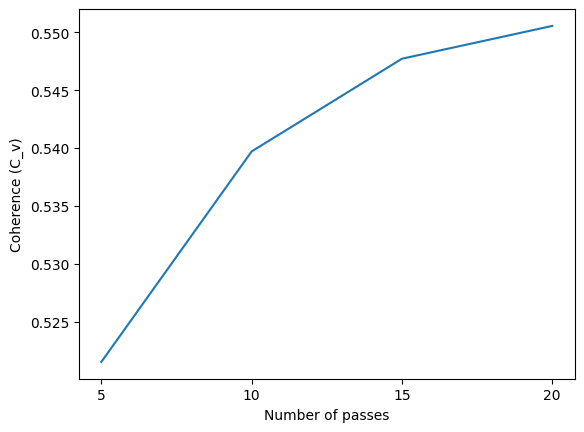

In [16]:
from matplotlib import pyplot as plt

plt.plot(results["pass_count"], results["coherence"])
plt.xticks([5, 10, 15, 20], [5, 10, 15, 20])
plt.xlabel("Number of passes")
plt.ylabel("Coherence (C_v)")
plt.show()

In [17]:
results2 = pd.DataFrame([25, 30], columns=["pass_count"])
results2["coherence"] = results2["pass_count"].apply(lambda x, c, d, p: lda_coherence(c, d, p, 62, x),
                                                     args=(bow_corpus, dictionary, processed_docs,))
results2.to_csv("tmp/20230511-clustering-finetuning-pass_count-2.csv")

In [28]:
results2 = pd.read_csv("tmp/20230511-clustering-finetuning-pass_count-2.csv")
results2

Unnamed: 0  pass_count  coherence
0           0          25   0.553989
1           1          30   0.554649

In [33]:
results = pd.concat([results, results2])
results.to_csv("tmp/20230511-clustering-finetuning-pass_count-all.csv")

In [34]:
results = pd.read_csv("tmp/20230511-clustering-finetuning-pass_count-all.csv")
results

Unnamed: 0.1  Unnamed: 0  pass_count  coherence
0             0           0           5   0.521512
1             1           1          10   0.539708
2             2           2          15   0.547723
3             3           3          20   0.550560
4             0           0          25   0.553989
5             1           1          30   0.554649

In [36]:
from matplotlib import pyplot as plt

plt.plot(results["pass_count"], results["coherence"])
plt.xticks([5, 10, 15, 20, 25, 30], [5, 10, 15, 20, 25, 30])
plt.xlabel("Number of passes")
plt.ylabel("Coherence (C_v)")
plt.show()

## Find best alpha/eta

In [63]:
alphas, etas = cartesian_product([
    [0.1, 0.5, 0.9, "asymmetric", "symmetric"],
    [0.1, 0.5, 0.9, "symmetric"]
])
results = pd.DataFrame(dict(alpha=alphas, eta=etas))
results

alpha        eta
0          0.1        0.1
1          0.1        0.5
2          0.1        0.9
3          0.1  symmetric
4          0.5        0.1
5          0.5        0.5
6          0.5        0.9
7          0.5  symmetric
8          0.9        0.1
9          0.9        0.5
10         0.9        0.9
11         0.9  symmetric
12  asymmetric        0.1
13  asymmetric        0.5
14  asymmetric        0.9
15  asymmetric  symmetric
16   symmetric        0.1
17   symmetric        0.5
18   symmetric        0.9
19   symmetric  symmetric

In [64]:
results["coherence"] = results.progress_apply(
    lambda x: lda_coherence(bow_corpus, dictionary, processed_docs, 60, 15, x["alpha"], x["eta"]), axis=1)
results.to_csv("tmp/20230511-clustering-finetuning-alpha-eta.csv")

 50%|█████     | 10/20 [2:14:28<2:14:28, 806.83s/it]


KeyboardInterrupt: 

In [5]:
results = pd.read_csv("tmp/20230511-clustering-finetuning-alpha-eta.csv")
results

Unnamed: 0       alpha        eta  coherence
0            0         0.1        0.1   0.554242
1            1         0.1        0.5   0.542987
2            2         0.1        0.9   0.522087
3            3         0.1  symmetric   0.553731
4            4         0.5        0.1   0.544493
5            5         0.5        0.5   0.538279
6            6         0.5        0.9   0.523998
7            7         0.5  symmetric   0.545798
8            8         0.9        0.1   0.532924
9            9         0.9        0.5   0.516736
10          10         0.9        0.9   0.517806
11          11         0.9  symmetric   0.530608
12          12  asymmetric        0.1   0.551584
13          13  asymmetric        0.5   0.541328
14          14  asymmetric        0.9   0.530259
15          15  asymmetric  symmetric   0.552153
16          16   symmetric        0.1   0.557241
17          17   symmetric        0.5   0.539985
18          18   symmetric        0.9   0.526897
19          19   symmetric  symmetric   0.554559

In [8]:
# Best coherence
results.iloc[results["coherence"].argmax()]

Unnamed: 0           16
alpha         symmetric
eta                 0.1
coherence      0.557241
Name: 16, dtype: object

## Topic study

In [11]:
lda_model = LdaModel(bow_corpus, num_topics=60, id2word=dictionary, passes=15, alpha='symmetric', eta=0.1,
                     minimum_probability=0.0, random_state=0)
for idx, topic in lda_model.print_topics(-1):
    print('-- Topic: {} --\n{}\n'.format(idx, topic))

-- Topic: 0 --
0.024*"insurance" + 0.023*"food" + 0.013*"machine" + 0.012*"catering" + 0.012*"fruit" + 0.011*"coffee" + 0.010*"gram" + 0.009*"weight" + 0.009*"fresh" + 0.008*"drink"

-- Topic: 1 --
0.099*"platform" + 0.036*"web" + 0.025*"portal" + 0.013*"functionality" + 0.011*"search" + 0.008*"host" + 0.008*"community" + 0.007*"digital" + 0.007*"infrastructure" + 0.006*"maintenance"

-- Topic: 2 --
0.018*"corruption" + 0.018*"offence" + 0.017*"abovementioned" + 0.014*"signatory" + 0.013*"supervisory" + 0.012*"debt" + 0.011*"officer" + 0.011*"attempt" + 0.011*"judicial" + 0.010*"competent"

-- Topic: 3 --
0.088*"medical" + 0.071*"health" + 0.022*"examination" + 0.014*"care" + 0.014*"test" + 0.014*"healthcare" + 0.014*"patient" + 0.011*"treatment" + 0.010*"clinical" + 0.010*"disease"

-- Topic: 4 --
0.010*"services" + 0.008*"damage" + 0.007*"tendering" + 0.007*"claim" + 0.006*"category" + 0.005*"assignment" + 0.005*"department" + 0.005*"classify" + 0.004*"audits" + 0.004*"conformity"

-

In [12]:
doc_topics = lda_model.get_document_topics(bow_corpus)

In [27]:
topic_cpvs = []
for doc_id, topics in tqdm(enumerate(doc_topics), total=len(doc_topics)):
    topic_id = max(topics, key=lambda x: x[1])[0]
    for _ in range(len(topic_cpvs), topic_id + 1):
        topic_cpvs.append([])
    doc = df.iloc[doc_id]
    topic_cpvs[topic_id].append([cpv_labels[c] for c in df.columns if len(c) == 2 and doc[c]])

100%|██████████| 3794/3794 [00:18<00:00, 200.06it/s]


In [28]:
for i, t in enumerate(topic_cpvs):
    print(f"Topic {i}: {len(t)} procurements")

Topic 0: 46 procurements
Topic 1: 26 procurements
Topic 2: 104 procurements
Topic 3: 48 procurements
Topic 4: 82 procurements
Topic 5: 104 procurements
Topic 6: 101 procurements
Topic 7: 45 procurements
Topic 8: 94 procurements
Topic 9: 149 procurements
Topic 10: 75 procurements
Topic 11: 80 procurements
Topic 12: 29 procurements
Topic 13: 81 procurements
Topic 14: 115 procurements
Topic 15: 137 procurements
Topic 16: 41 procurements
Topic 17: 27 procurements
Topic 18: 64 procurements
Topic 19: 41 procurements
Topic 20: 66 procurements
Topic 21: 56 procurements
Topic 22: 69 procurements
Topic 23: 162 procurements
Topic 24: 235 procurements
Topic 25: 78 procurements
Topic 26: 92 procurements
Topic 27: 1 procurements
Topic 28: 26 procurements
Topic 29: 0 procurements
Topic 30: 90 procurements
Topic 31: 35 procurements
Topic 32: 64 procurements
Topic 33: 41 procurements
Topic 34: 3 procurements
Topic 35: 53 procurements
Topic 36: 43 procurements
Topic 37: 42 procurements
Topic 38: 34 proc

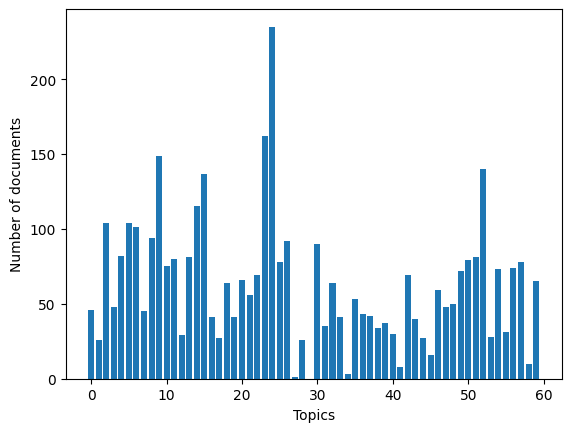

In [37]:
from matplotlib import pyplot as plt

plt.bar(range(len(topic_cpvs)), [len(t) for t in topic_cpvs])
plt.xlabel("Topics")
plt.ylabel("Number of documents")
plt.show()

In [52]:
for i, cpvs in enumerate(topic_cpvs):
    cpv_counter = Counter([c for t in cpvs for c in t])
    print(f"-- Topic: {i} --")
    for t, c in cpv_counter.most_common(3):
        print(f"{t} ({c})")
    print()

-- Topic: 0 --
Hotel, restaurant and retail trade services (18)
Financial and insurance services (12)
Research and development services and related consultancy services (6)

-- Topic: 1 --
IT services: consulting, software development, Internet and support (9)
Business services: law, marketing, consulting, recruitment, printing and security (8)
Research and development services and related consultancy services (3)

-- Topic: 2 --
Business services: law, marketing, consulting, recruitment, printing and security (23)
Research and development services and related consultancy services (20)
Sewage-, refuse-, cleaning-, and environmental services (7)

-- Topic: 3 --
Health and social work services (32)
Research and development services and related consultancy services (6)
Software package and information systems (3)

-- Topic: 4 --
Business services: law, marketing, consulting, recruitment, printing and security (22)
Financial and insurance services (17)
IT services: consulting, software dev

In [59]:
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary=lda_model.id2word)
pyLDAvis.save_html(vis, 'tmp/20230515-lda-60topics.html')

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/pyLDAvis/_prepare.py:244: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)


## Clustering

In [53]:
doc_probabilities = np.zeros((len(bow_corpus), lda_model.num_topics))
for doc_id, topics in enumerate(doc_topics):
    for topic, prob in topics:
        doc_probabilities[doc_id, topic] = prob

In [54]:
distance_matrix = np.zeros((len(bow_corpus), len(bow_corpus)))
for doc1_id in tqdm(range(len(bow_corpus)), total=len(bow_corpus)):
    for doc2_id in range(len(bow_corpus)):
        distance_matrix[doc1_id, doc2_id] = jensenshannon(doc_probabilities[doc1_id], doc_probabilities[doc2_id])

 50%|████▉     | 1880/3794 [02:35<02:24, 13.24it/s]/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/scipy/spatial/distance.py:1300: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(js / 2.0)
100%|██████████| 3794/3794 [05:07<00:00, 12.33it/s]


In [55]:
distance_matrix[np.isnan(distance_matrix)] = -1

In [79]:
clustering_model = AgglomerativeClustering(n_clusters=45, affinity='precomputed', linkage='average')

In [80]:
clusters = clustering_model.fit_predict(distance_matrix)

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [81]:
cluster_cpvs = []
for doc_id, cluster_id in tqdm(enumerate(clusters), total=len(clusters)):
    for _ in range(len(cluster_cpvs), cluster_id + 1):
        cluster_cpvs.append([])
    doc = df.iloc[doc_id]
    cluster_cpvs[cluster_id].append([cpv_labels[c] for c in df.columns if len(c) == 2 and doc[c]])

100%|██████████| 3794/3794 [00:00<00:00, 8367.09it/s]


In [83]:
from matplotlib import pyplot as plt

plt.bar(range(len(cluster_cpvs)), [len(t) for t in cluster_cpvs])
plt.xlabel("Cluster IDs")
plt.ylabel("Number of notices")
plt.show()

In [72]:
for i, cpvs in enumerate(cluster_cpvs):
    cpv_counter = Counter([c for t in cpvs for c in t])
    print(f"-- Cluster: {i} --")
    for t, c in cpv_counter.most_common(3):
        print(f"{t} ({c})")
    print()

-- Cluster: 0 --
Health and social work services (32)
Business services: law, marketing, consulting, recruitment, printing and security (32)
IT services: consulting, software development, Internet and support (20)

-- Cluster: 1 --
Business services: law, marketing, consulting, recruitment, printing and security (90)
Research and development services and related consultancy services (75)
IT services: consulting, software development, Internet and support (22)

-- Cluster: 2 --
IT services: consulting, software development, Internet and support (53)
Business services: law, marketing, consulting, recruitment, printing and security (14)
Architectural, construction, engineering and inspection services (12)

-- Cluster: 3 --
Business services: law, marketing, consulting, recruitment, printing and security (63)
Architectural, construction, engineering and inspection services (48)
Financial and insurance services (13)

-- Cluster: 4 --
Health and social work services (48)
Transport services (

In [84]:
clustering_model = AgglomerativeClustering(n_clusters=10, affinity='precomputed', linkage='average')

In [85]:
clusters = clustering_model.fit_predict(distance_matrix)

/home/ferreni/Projects/TED AI/Repositories/tedai-cpv-classification/venv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [86]:
cluster_cpvs = []
for doc_id, cluster_id in tqdm(enumerate(clusters), total=len(clusters)):
    for _ in range(len(cluster_cpvs), cluster_id + 1):
        cluster_cpvs.append([])
    doc = df.iloc[doc_id]
    cluster_cpvs[cluster_id].append([cpv_labels[c] for c in df.columns if len(c) == 2 and doc[c]])

100%|██████████| 3794/3794 [00:00<00:00, 8559.11it/s]


In [88]:
from matplotlib import pyplot as plt

plt.bar(range(len(cluster_cpvs)), [len(t) for t in cluster_cpvs])
plt.xlabel("Cluster IDs")
plt.ylabel("Number of notices")
plt.show()

In [76]:
for i, cpvs in enumerate(cluster_cpvs):
    cpv_counter = Counter([c for t in cpvs for c in t])
    print(f"-- Cluster: {i} --")
    for t, c in cpv_counter.most_common(3):
        print(f"{t} ({c})")
    print()

-- Cluster: 0 --
Research and development services and related consultancy services (76)
Health and social work services (50)
IT services: consulting, software development, Internet and support (29)

-- Cluster: 1 --
Business services: law, marketing, consulting, recruitment, printing and security (310)
IT services: consulting, software development, Internet and support (298)
Education and training services (106)

-- Cluster: 2 --
Business services: law, marketing, consulting, recruitment, printing and security (145)
IT services: consulting, software development, Internet and support (6)
Recreational, cultural and sporting services (5)

-- Cluster: 3 --
Laboratory, optical and precision equipments (excl. glasses) (88)
Sewage-, refuse-, cleaning-, and environmental services (39)
Repair and maintenance services (35)

-- Cluster: 4 --
Business services: law, marketing, consulting, recruitment, printing and security (551)
Research and development services and related consultancy services (